In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from local_plot import *
from utils import *
from trajectory import *
import re
import matplotlib.pyplot as plt
import os

#Apply default style to all plots
plt.style.use('seaborn-whitegrid')
#Set default font size
plt.rcParams.update({'font.size': 25})

In [37]:
def extract_average_iter_time(log_content):
    # Sample log content:
    # [D2VINS::solveDist@5](6364) odom Pose T [-1.029,-0.423,+0.135] YPR [+109.4,+0.1,+0.4] Vel 0.55 -0.25 0.87@ref1 landmarks 195/195 v_mea 923/1500 drone_num 5 opti_time 8.5ms steps 5 td 0.0ms 
    # Extract average opti_time using and steps using regular expression
    pattern = re.compile(r"landmarks \d+/\d+ v_mea \d+/\d+ drone_num \d+ opti_time (\d+.\d+)ms steps (\d+) td -?\d+.\d+ms")
    matches = re.findall(pattern, log_content)
    opti_time = np.array([float(match[0]) for match in matches])
    steps = np.array([float(match[1]) for match in matches])
    return opti_time / steps


def extract_marginalization_time(log_content):
    # Sample log content:
    # [D2VINS::marginalize] time cost 10.0ms frame_id 5001166 total_eff_state_dim: 209 keep_size 124 remove size 85 eff_residual_size: 845 keep_block_size 21 
    # Extract marginalization time using regular expression
    pattern = re.compile(r"\[D2VINS::marginalize\] time cost (\d+.\d+)ms frame_id \d+ total_eff_state_dim: \d+ keep_size \d+ remove size \d+ eff_residual_size: \d+ keep_block_size \d+")
    matches = re.findall(pattern, log_content)
    return np.array(matches).astype(float)
    

def process_log_file(log_file, verbose=False):
    with open(log_file, "r") as f:
        log_content = f.read()
        iter_times = extract_average_iter_time(log_content)
        marginalization_times = extract_marginalization_time(log_content)
        if verbose:
            print(f"Average iteration time: {np.mean(iter_times):3.1f}ms +- {np.std(iter_times):3.1f}ms")
            print(f"Average marginalization time: {np.mean(marginalization_times):3.1f}ms +- {np.std(marginalization_times):3.1f}ms")
    return iter_times, marginalization_times


def process_data(datas, paths_gt, t0, figsize=(10, 5), nodes=range(1, 6), max_iter_time=15, max_marginalization_time=50, save_path=""):
    # Print and plot the average iteration time and marginalization time
    # Initialize the figure for average iteration time
    fig, ax = plt.subplots(figsize=figsize)
    # ax.set_title("Average Iteration Time")
    ax.set_xlabel("Drone Number")
    ax.set_ylabel("Avg. Iter. Time (ms)")

    # Initialize the figure for average marginalization time
    fig2, ax2 = plt.subplots(figsize=figsize)
    # ax2.set_title("Average Marginalization Time")
    ax2.set_xlabel("Drone Number")
    ax2.set_ylabel("Avg. Margin. Time (ms)")

    # Initialize the figure for ATE translation
    fig3, ax3 = plt.subplots(figsize=figsize)
    ax3.set_xlabel("Drone Number")
    ax3.set_ylabel("Avg. $ATE_{pos}$ (m)")

    # Initialize the figure for ATE rotation
    fig4, ax4 = plt.subplots(figsize=figsize)
    ax4.set_xlabel("Drone Number")
    ax4.set_ylabel("Avg. $ATE_{rot}$ (deg)")

    # Initialize the figure for RE translation
    fig5, ax5 = plt.subplots(figsize=figsize)
    ax5.set_xlabel("Drone Number")
    ax5.set_ylabel("Avg. Relative Error (m)")

    # Initialize the figure for RE rotation
    fig6, ax6 = plt.subplots(figsize=figsize)
    ax6.set_xlabel("Drone Number")
    ax6.set_ylabel("Avg. Relative Rotation Error (deg)")

    # Iterate through all the data
    for max_measurements, data in datas.items():
        # Initialize the data for average iteration time
        drone_nums = []
        drone_nums_RE = []
        iter_times = []
        iter_time_stds = []

        # Initialize the data for average marginalization time
        marginalization_times = []
        marginalization_time_stds = []

        ATE_trans = []
        ATE_rot = []
        RE_trans = []
        RE_rot = []

        # Iterate through all the data for a specific max_measurements
        for drone_num, path in data:
            # Iterate through all the drones and average the time
            _iter_times = []
            _marginalization_times = []
            nodes = range(1, drone_num + 1)
            for i in nodes:
                # Process the log file
                log_file = os.path.join(path, f"swarm{i}/d2slam.log")
                _iter_times_,  _marginalization_times_ = process_log_file(log_file)
                # Concatenate the data
                _iter_times = np.concatenate((_iter_times, _iter_times_))
                _marginalization_times = np.concatenate((_marginalization_times, _marginalization_times_))
            _iter_times = np.array(_iter_times)
            _marginalization_times = np.array(_marginalization_times)
            drone_nums.append(drone_num)
            iter_times.append(np.mean(_iter_times))
            iter_time_stds.append(np.std(_iter_times))
            marginalization_times.append(np.mean(_marginalization_times))
            marginalization_time_stds.append(np.std(_marginalization_times))

            #Read path and calculate ATE
            paths, _, _ = read_multi_folder(path + "/swarm", nodes, False, t0=t0)
            align_paths(paths, paths_gt, True, True)
            ate_pos, ate_ang = plot_fused_err(nodes, paths, paths_gt, show=False, output_ATE=True)
            ATE_trans.append(ate_pos)
            ATE_rot.append(ate_ang*180/pi)
            if drone_num > 1:
                re_pos, re_ang = relative_pose_err(nodes, paths, paths_gt, output_RE=True)
                RE_trans.append(re_pos)
                RE_rot.append(re_ang*180/pi)
                drone_nums_RE.append(drone_num)
            
        # Plot the average iteration time
        ax.errorbar(drone_nums, iter_times, yerr=iter_time_stds, label=f"$\\tau_m=${max_measurements}", fmt='o--', capsize=15)

        # Plot the average marginalization time
        ax2.errorbar(drone_nums, marginalization_times, yerr=marginalization_time_stds, label=f"$\\tau_m=${max_measurements}", fmt='o--', capsize=15)

        # Plot the ATE translation
        ax3.plot(drone_nums, ATE_trans, label=f"$\\tau_m=${max_measurements}", marker='o')
        ax4.plot(drone_nums, ATE_rot, label=f"$\\tau_m=${max_measurements}", marker='o')

        # Plot the RE translation
        ax5.plot(drone_nums_RE, RE_trans, label=f"$\\tau_m=${max_measurements}", marker='o')
        ax6.plot(drone_nums_RE, RE_rot, label=f"$\\tau_m=${max_measurements}", marker='o')

    ax.set_ylim(0, max_iter_time)
    ax2.set_ylim(0, max_marginalization_time)
    ax.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    ax5.legend()
    ax6.legend()
    # Set x ticks 
    ax.set_xticks(drone_nums)
    ax2.set_xticks(drone_nums)
    ax3.set_xticks(drone_nums)
    ax4.set_xticks(drone_nums)
    ax5.set_xticks(drone_nums_RE)
    ax6.set_xticks(drone_nums_RE)
    # Save the figures
    if save_path != "":
        fig.savefig(save_path + "iter_time.png", bbox_inches='tight')
        fig2.savefig(save_path + "marginalization_time.png", bbox_inches='tight')
        fig3.savefig(save_path + "ATE_trans.png", bbox_inches='tight')
        fig4.savefig(save_path + "ATE_rot.png", bbox_inches='tight')
        fig5.savefig(save_path + "RE_trans.png", bbox_inches='tight')
        fig6.savefig(save_path + "RE_rot.png", bbox_inches='tight')



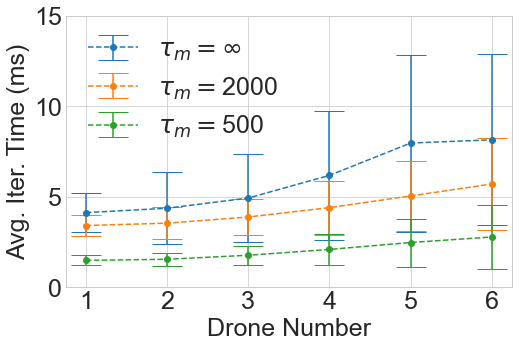

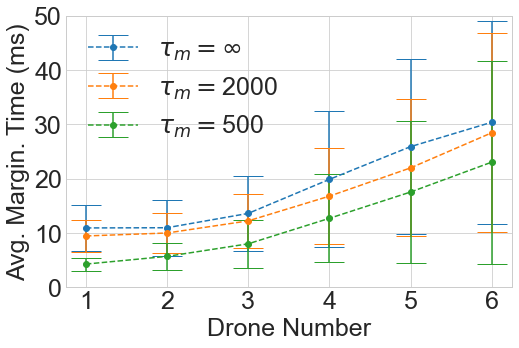

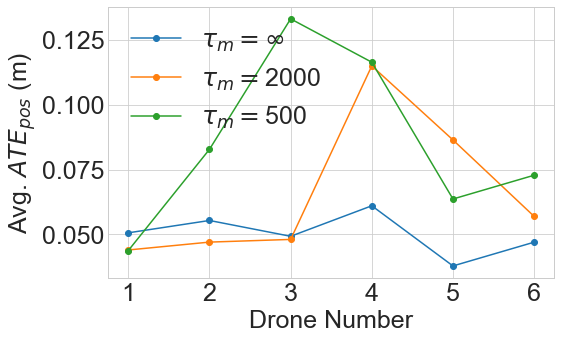

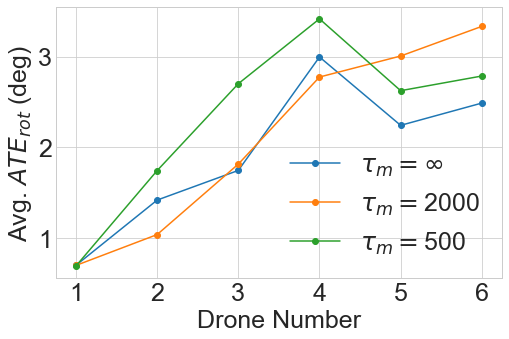

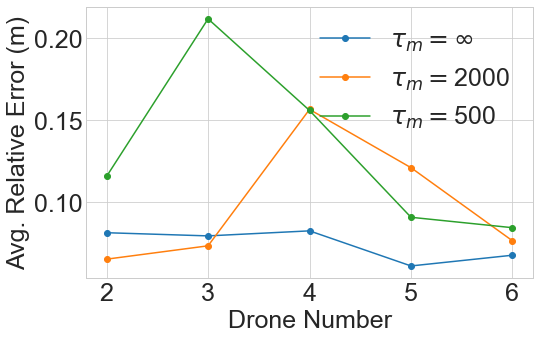

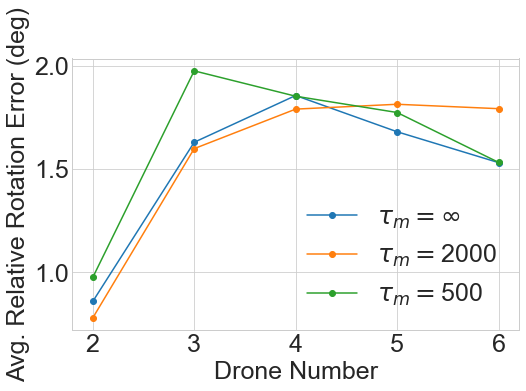

In [38]:
# max_measurements: [Drone Num, path]
Datas = {
    "$\\infty$": [(1, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_1_mea0/"),
    (2, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_2_mea0/"),
    (3, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_3_mea0/"),
    (4, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_4_mea0/"),
    (5, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_5_mea0/"),
    (6, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_6_mea0/")],
    2000: [(1, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_1_mea2000/"),
    (2, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_2_mea2000/"),
    (3, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_3_mea2000/"),
    (4, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_4_mea2000/"),
    (5, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_5_mea2000/"),
    (6, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_6_mea2000/")],
    # 1500: [(1, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_1_mea1500/"),
    # (2, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_2_mea1500/"),
    # (3, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_3_mea1500/"),
    # (4, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_4_mea1500/"),
    # (5, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_5_mea1500/"),
    # (6, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_6_mea1500/")],
    500: [(1, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_1_mea500/"),
    (2, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_2_mea500/"),
    (3, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_3_mea500/"),
    (4, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_4_mea500/"),
    (5, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_5_mea500/"),
    (6, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_6_mea500/")],
    # 1000: [
    # (1, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_1_mea1000/"),
    # (2, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_2_mea1000/"),
    # (3, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_3_mea1000/"),
    # (4, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_4_mea1000/"),
    # (5, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_5_mea1000/"),
    # (6, "/home/xuhao/data/d2slam/tum_datasets/outputs/d2vins_6_mea1000/")],
}
data_folder = "/home/xuhao/data/d2slam/tum_datasets/"
nodes = range(1, 7)
paths_gt, t0 = read_paths(data_folder, nodes, prefix="groundtruth_")
process_data(Datas, paths_gt, t0, nodes=nodes, save_path="/home/xuhao/Dropbox/my_publications/TRO-2022-D2SLAM/figs/gen/scability_stereo_", figsize=(8, 5))

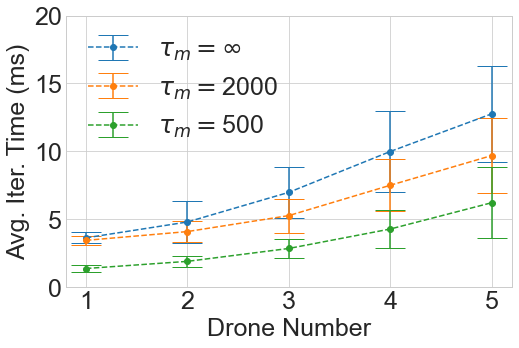

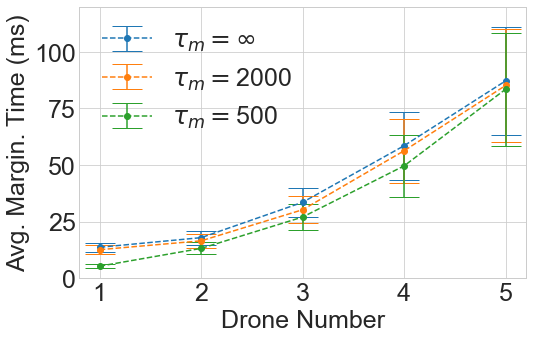

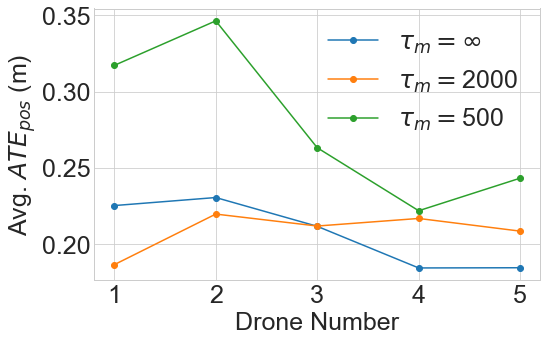

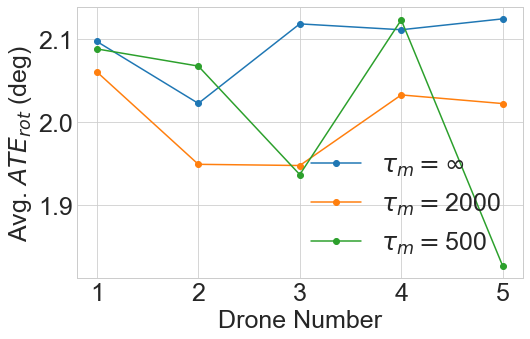

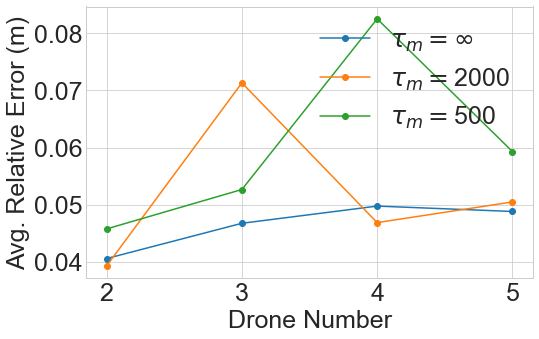

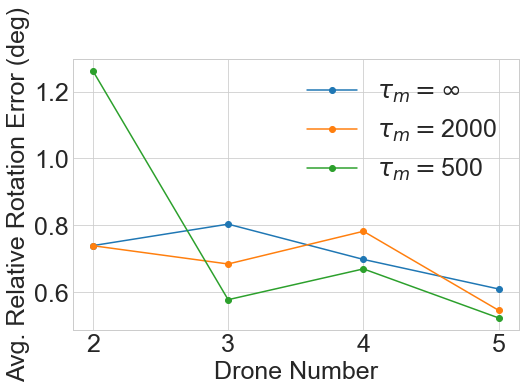

In [40]:
# max_measurements: [Drone Num, path]
Datas = {
    "$\\infty$": [
    (1, "/media/xuhao/Games/data/quadcam_7inch_n3_2023_1_14/outputs/d2vins_1_mea0/"),
    (2, "/home/xuhao/data/d2slam/quadcam_7inch_n3_2023_1_14/outputs/d2vins_2_mea0/"),
    (3, "/home/xuhao/data/d2slam/quadcam_7inch_n3_2023_1_14/outputs/d2vins_3_mea0/"),
    (4, "/home/xuhao/data/d2slam/quadcam_7inch_n3_2023_1_14/outputs/d2vins_4_mea0/"),
    (5, "/home/xuhao/data/d2slam/quadcam_7inch_n3_2023_1_14/outputs/d2vins_5_mea0/"),
    ],
    2000: [(1, "/home/xuhao/data/d2slam/quadcam_7inch_n3_2023_1_14/outputs/d2vins_1_mea2000/"),
    (2, "/home/xuhao/data/d2slam/quadcam_7inch_n3_2023_1_14/outputs/d2vins_2_mea2000/"),
    (3, "/home/xuhao/data/d2slam/quadcam_7inch_n3_2023_1_14/outputs/d2vins_3_mea2000/"),
    (4, "/home/xuhao/data/d2slam/quadcam_7inch_n3_2023_1_14/outputs/d2vins_4_mea2000/"),
    (5, "/home/xuhao/data/d2slam/quadcam_7inch_n3_2023_1_14/outputs/d2vins_5_mea2000/")],
    # 1000: [(1, "/home/xuhao/data/d2slam/quadcam_7inch_n3_2023_1_14/outputs/d2vins_1_mea1000/"),
    # (2, "/home/xuhao/data/d2slam/quadcam_7inch_n3_2023_1_14/outputs/d2vins_2_mea1000/"),
    # (3, "/home/xuhao/data/d2slam/quadcam_7inch_n3_2023_1_14/outputs/d2vins_3_mea1000/"),
    # (4, "/home/xuhao/data/d2slam/quadcam_7inch_n3_2023_1_14/outputs/d2vins_4_mea1000/"),
    # (5, "/home/xuhao/data/d2slam/quadcam_7inch_n3_2023_1_14/outputs/d2vins_5_mea1000/")],
    # 3000: [
    # (1, "/home/xuhao/data/d2slam/quadcam_7inch_n3_2023_1_14/outputs/d2vins_1_mea3000/"),
    # (2, "/home/xuhao/data/d2slam/quadcam_7inch_n3_2023_1_14/outputs/d2vins_2_mea3000/"),
    # (3, "/home/xuhao/data/d2slam/quadcam_7inch_n3_2023_1_14/outputs/d2vins_3_mea3000/"),
    # (4, "/home/xuhao/data/d2slam/quadcam_7inch_n3_2023_1_14/outputs/d2vins_4_mea3000/"),
    # (5, "/home/xuhao/data/d2slam/quadcam_7inch_n3_2023_1_14/outputs/d2vins_5_mea3000/")],
    500: [
    (1, "/home/xuhao/data/d2slam/quadcam_7inch_n3_2023_1_14/outputs/d2vins_1_mea500/"),
    (2, "/home/xuhao/data/d2slam/quadcam_7inch_n3_2023_1_14/outputs/d2vins_2_mea500/"),
    (3, "/home/xuhao/data/d2slam/quadcam_7inch_n3_2023_1_14/outputs/d2vins_3_mea500/"),
    (4, "/home/xuhao/data/d2slam/quadcam_7inch_n3_2023_1_14/outputs/d2vins_4_mea500/"),
    (5, "/home/xuhao/data/d2slam/quadcam_7inch_n3_2023_1_14/outputs/d2vins_5_mea500/"),]
}

data_folder="/home/xuhao/data/d2slam/quadcam_7inch_n3_2023_1_14/"
nodes = range(1, 7)
paths_gt, t0 = read_paths(data_folder, nodes, prefix="eight_yaw_", suffix="-groundtruth.txt")
process_data(Datas, paths_gt, t0, nodes=nodes, max_iter_time=20, max_marginalization_time=120, save_path="/home/xuhao/Dropbox/my_publications/TRO-2022-D2SLAM/figs/gen/scability_omni_", figsize=(8, 5))

In [16]:
import sys
sys.path.insert(0,'../d2pgo/scripts')
from simulate_door_slam import *

def evaluate_pgo_scailibity(g2o_path, g2o_input, max_steps=100, eta_k=1.45, rho_frame_T=0.39, 
            rho_frame_theta=1.556, simulate_delay_ms=0.0, verify_accuaracy=False, max_agent_num=5, dgs_max_steps=50, 
            max_solving_time=10.0, rho_rot_mat=0.09):
    ignore_infor = False
    pg = PoseGraph(g2o_input)
    rot_init_times = []
    cere_per_iters = []
    rot_init_time_std = []
    cere_per_iters_std = []
    drone_nums = []
    for agent_num in range(1, max_agent_num + 1):
        print(f"Initial cost: {pg.evaluate_cost():.1f} edges {len(pg.edges)} num {agent_num}")
        output_path=g2o_path + "/d2pgo-rot-inited/"
        pgo_optimized, ret = call_d2pgo_opti(g2o_folder=g2o_input, output_folder=output_path, enable_rot_init=True, 
            max_steps=max_steps, agent_num=agent_num, ignore_infor=ignore_infor, eta_k=eta_k, rho_frame_theta=rho_frame_theta, 
            rho_frame_T=rho_frame_T, rho_rot_mat=rho_rot_mat, simulate_delay_ms=simulate_delay_ms, max_solving_time=max_solving_time)
        rot_init_time = ret["rot_init_time"]
        cere_per_iter = ret["cere_per_iter"]
        rot_init_times.append(np.mean(rot_init_time))
        cere_per_iters.append(np.mean(cere_per_iter))
        rot_init_time_std.append(np.std(rot_init_time))
        cere_per_iters_std.append(np.std(cere_per_iter))
        drone_nums.append(agent_num)
    return drone_nums, rot_init_times, cere_per_iters, rot_init_time_std, cere_per_iters_std

def plot(drone_nums, rot_init_times, cere_per_iters, rot_init_time_std, cere_per_iters_std, figsize=(8, 5), save_path=""):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlabel("Drone Number")
    ax.set_ylabel("Avg. Iter. Time (ms)")

    fig2, ax2 = plt.subplots(figsize=figsize)
    ax2.set_xlabel("Drone Number")
    ax2.set_ylabel("Avg. RotInit. Iter. Time (ms)")
    ax.errorbar(drone_nums, cere_per_iters, yerr=cere_per_iters_std, fmt='o--', capsize=15)
    ax2.errorbar(drone_nums, rot_init_times, yerr=rot_init_time_std, fmt='o--', capsize=15)
    if save_path != "":
        fig.savefig(save_path + "arock_iter_time.png", bbox_inches='tight')
        fig2.savefig(save_path + "rotinit_time.png", bbox_inches='tight')

Initial cost: 350408.6 edges 16814 num 1
Initial cost: 350408.6 edges 16814 num 2
Initial cost: 350408.6 edges 16814 num 3
Initial cost: 350408.6 edges 16814 num 4
Initial cost: 350408.6 edges 16814 num 5


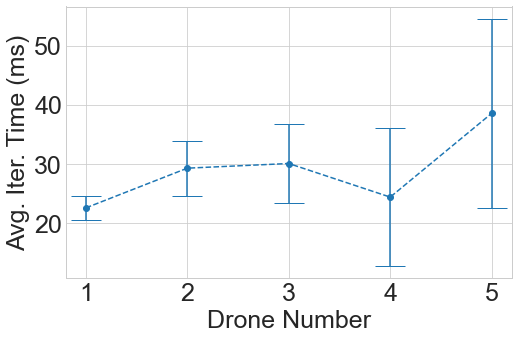

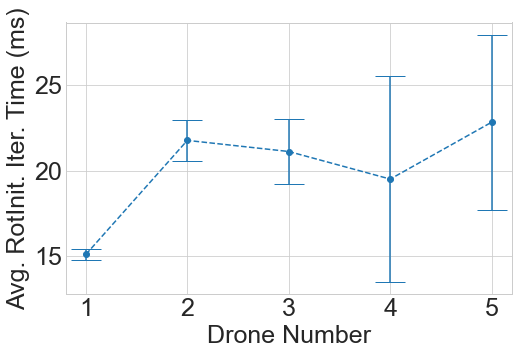

In [20]:

g2o_path="/home/xuhao/data/d2slam/pgo/tum_corr_5/"
# g2o_path="/home/xuhao/data/d2slam/pgo/ri_realsense_walkaround_2022_10/"
g2o_input = g2o_path + "/input/"
max_steps = 1000
eta_k=1.5101010101010102
rho_frame_T=0.4526572657265727
rho_frame_theta=2.868058805880588
rho_rot_mat =0.0918787878787879
simulate_delay_ms=0.0
max_solving_time = 20.0
drone_nums, rot_init_times, cere_per_iters, rot_init_time_std, cere_per_iters_std = evaluate_pgo_scailibity(g2o_path, 
            g2o_input, max_steps=max_steps, eta_k=eta_k, rho_frame_T=rho_frame_T, rho_frame_theta=rho_frame_theta, 
            simulate_delay_ms=simulate_delay_ms, max_solving_time=max_solving_time, rho_rot_mat=rho_rot_mat, max_agent_num=5)
plot(drone_nums, rot_init_times, cere_per_iters, rot_init_time_std, cere_per_iters_std, save_path="/home/xuhao/Dropbox/my_publications/TRO-2022-D2SLAM/figs/gen/scability_pgo_")